# Global Population Assessment

**Data Source**
1. GPWv411:  (Gridded Population of the World Version 4.11) 2000, 2005, 2010, 2015, 2020
Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Population Density, Revision 11. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H49C6VHW. Accessed DAY MONTH YEAR.

2. GHSL: Global Human Settlement Layers, Population Grid 1975-1990-2000-2015
European Commission, Joint Research Centre (JRC); Columbia University, Center for International Earth Science Information Network - CIESIN (2015): GHS population grid, derived from GPW4, multitemporal (1975, 1990, 2000, 2015). European Commission, Joint Research Centre (JRC) [Dataset] PID: https://data.europa.eu/89h/jrc-ghsl-ghs_pop_gpw4_globe_r2015a

3. World Population


In [1]:
%matplotlib inline
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

In [2]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection)
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Jambi
All data will be reprojected to  EPSG:32748
Column name is  PROVINSI


In [5]:
# output directory
out_dir = os.path.expanduser(output_directory+'/geemap_PopulationAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [6]:
roi = gpd.read_file(roi_directory.name)
roi_proj  = roi.to_crs(crs = projection)

In [7]:
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)

In [8]:
# For Time lapse animation
roi_proj_4326 = roi.to_crs(crs = "EPSG:4326")
roi_proj_4326_gee = geemap.geopandas_to_ee(roi_proj_4326, geodesic=False)
        
bounds_roi = roi_proj_4326.total_bounds
bbox_roi = [bounds_roi[2], bounds_roi[1], bounds_roi[0], bounds_roi[3]]

In [9]:
# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}

In [10]:
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

## GPWv411: Population Density (Gridded Population of the World Version 4.11)

The Gridded Population of World Version 4 (GPWv4), Revision 11 models the distribution of global human population for the years 2000, 2005, 2010, 2015, and 2020 
on 30 arc-second (approximately 1km) grid cells. These population density grids contain estimates of the number of persons per square kilometer consistent 
with national censuses and population registers. There is one image for each modeled year.

The value represent the estimated number of persons per square kilometer.

In [11]:
# Population Density 2000
GPWdataset_2000 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2000-01-01', '2000-12-31').first()
GPWdataset_2000_proj = GPWdataset_2000.reproject(crs = projection, scale = 1000)
GPW_PopDensity_2000_proj = GPWdataset_2000_proj.select('population_density').clip(roi_proj_gee)
# Population Density 2005
GPWdataset_2005 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2005-01-01', '2005-12-31').first()
GPWdataset_2005_proj = GPWdataset_2005.reproject(crs = projection, scale = 1000)
GPW_PopDensity_2005_proj = GPWdataset_2005_proj.select('population_density').clip(roi_proj_gee)
# Population Density 2010
GPWdataset_2010 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2010-01-01', '2010-12-31').first()
GPWdataset_2010_proj = GPWdataset_2010.reproject(crs = projection, scale = 1000)
GPW_PopDensity_2010_proj = GPWdataset_2010_proj.select('population_density').clip(roi_proj_gee)
# Population Density 2015
GPWdataset_2015 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2015-01-01', '2015-12-31').first()
GPWdataset_2015_proj = GPWdataset_2015.reproject(crs = projection, scale = 1000)
GPW_PopDensity_2015_proj = GPWdataset_2015_proj.select('population_density').clip(roi_proj_gee)
# Population Density 2020
GPWdataset_2020 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2020-01-01', '2020-12-31').first()
GPWdataset_2020_proj = GPWdataset_2020.reproject(crs = projection, scale = 1000)
GPW_PopDensity_2020_proj = GPWdataset_2020_proj.select('population_density').clip(roi_proj_gee)

In [12]:
popden_visParameter = {'palette': ['ffffe7', 'FFc869', 'ffac1d','e17735', 'f2552c', '9f0c21'], 'min' : 0, 'max': 500};
colors_GPW = ['ffffe7', 'FFc869', 'ffac1d','e17735', 'f2552c', '9f0c21']
cmap_GPWPopDens = ListedColormap(colors_GPW)

In [13]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

Map.centerObject(roi_proj_gee, 8)

# Add individual layer map
Map.addLayer(GPW_PopDensity_2000_proj, popden_visParameter, 'RoI - GPW Population Density 2000')
Map.addLayer(GPW_PopDensity_2005_proj, popden_visParameter, 'RoI - GPW Population Density 2005')
Map.addLayer(GPW_PopDensity_2010_proj, popden_visParameter, 'RoI - GPW Population Density 2010')
Map.addLayer(GPW_PopDensity_2015_proj, popden_visParameter, 'RoI - GPW Population Density 2015')
Map.addLayer(GPW_PopDensity_2020_proj, popden_visParameter, 'RoI - GPW Population Density 2020')
Map.addLayer(roi_proj_gee.style(**vis_roi), {}, "Region of Interest")

Map

Map(center=[-1.698463590692844, 102.71996498503798], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
SplitMap = geemap.Map()
SplitMap.add_basemap('HYBRID')

SplitMap.centerObject(roi_proj_gee, 8)

left_layer = geemap.ee_tile_layer(GPW_PopDensity_2000_proj, popden_visParameter, 'GPW Population Density 2000')
right_layer = geemap.ee_tile_layer(GPW_PopDensity_2020_proj, popden_visParameter, 'GPW Population Density 2020')
SplitMap.split_map(left_layer, right_layer)
SplitMap

Map(center=[-1.698463590692844, 102.71996498503798], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Export Data

#### Map and Timelapse

In [15]:
years_GPW = ee.List.sequence(2000, 2020, 5)

def get_GPW_images(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density')
        .filter(ee.Filter.date(start_date, end_date))
        .first()
        .clip(roi_proj_4326_gee)
    )
    return ee.Image(image)

collection_GPW = ee.ImageCollection(years_GPW.map(get_GPW_images))

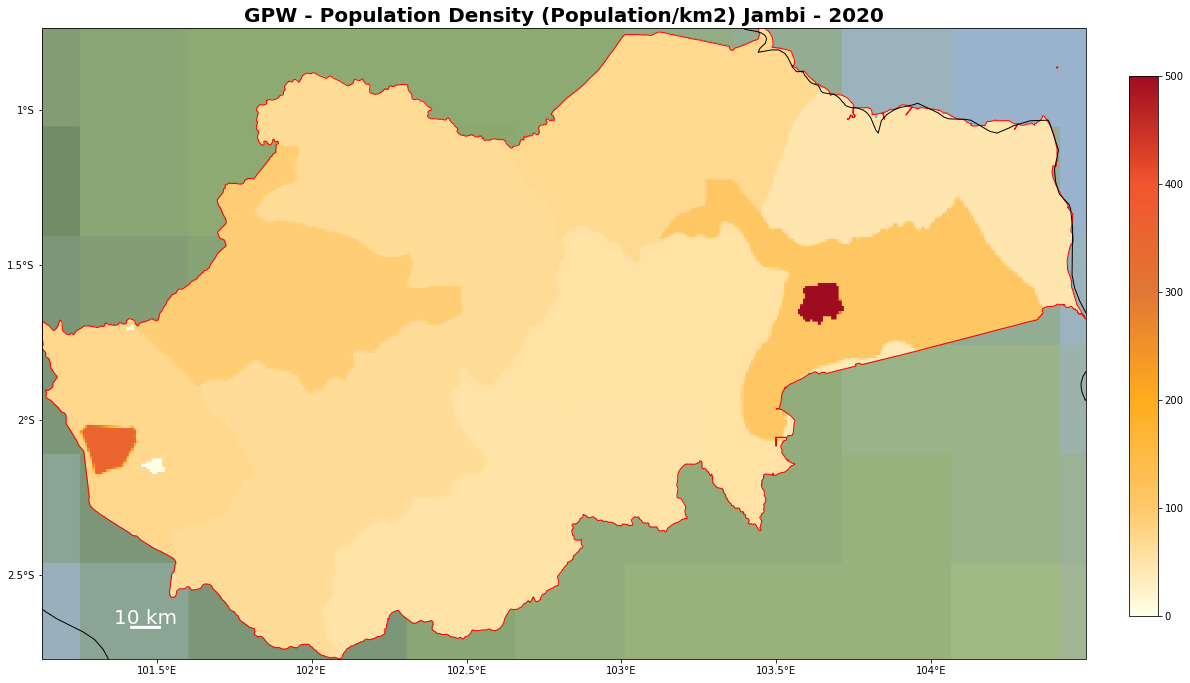

In [16]:
GPWdataset = ee.ImageCollection(ee.List.sequence(2020,2020,1).map(get_GPW_images)).first()
fig = plt.figure(figsize=(20, 15),  facecolor = 'white', frameon=True)

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(
    GPWdataset,
    vis_params=popden_visParameter,
    region=bbox_roi,
    basemap=cimgt.Stamen('terrain'),
    zoom_level=2,
)
ax = roi_proj_4326.plot(color = None, edgecolor = 'red', facecolor="none", ax = ax)
cb = cartoee.add_colorbar(ax, vis_params=popden_visParameter, loc='right', cmap = cmap_GPWPopDens )

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.5, 0.5],alpha=0, linestyle=":")
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
ax.set_title(label='GPW - Population Density (Population/km2) '+  projectname + " - 2020", fontsize=20, fontweight="bold")
ax.coastlines()
# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig(os.path.join(out_dir, projectname + '_GPW_PopDensity2020_Map.png'), bbox_inches='tight', 
            facecolor=fig.get_facecolor())
plt.show()

In [17]:
#GPW_timelapse_visParam = {'bands' : 'population_density', 'palette': ['ffffe7', 'FFc869', 'ffac1d','e17735', 'f2552c', '9f0c21'], 'min' : 0, 'max': 500}
#GPW_timelapse_visParam = {'bands' : ['population_density'], 'min' : 0, 'max': 100}
cartoee.get_image_collection_gif(
    ee_ic = collection_GPW,
    out_dir = os.path.expanduser(out_dir + '/GPW_TimeLapse_PopDens'),
    out_gif = projectname + "_GPW_PopDens2000_2020.gif",
    vis_params = popden_visParameter,
    region = bbox_roi,
    #cmap = cmap_GPWPopDens,
    fps = 5,
    mp4 = False,
    grid_interval = (0.5, 0.5),
    plot_title = projectname + " - Population Density (Population/km2)",
    date_format='YYYY',
    fig_size=(15, 12),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

GIF saved to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Global Population Assessment\Jambi_Demo\geemap_PopulationAssessment\GPW_TimeLapse_PopDens\Jambi_GPW_PopDens2000_2020.gif


#### Raster data

In [18]:
# 1. GPW Population Density 2000
geemap.ee_export_image_to_drive(
    GPW_PopDensity_2000_proj,
    description = projectname + '_GPW_PopDensity_2000_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GPW_PopDensity_2000_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. GPW Population Density 2005
geemap.ee_export_image_to_drive(
    GPW_PopDensity_2005_proj,
    description = projectname + '_GPW_PopDensity_2005_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GPW_PopDensity_2005_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 3. GPW Population Density 2010
geemap.ee_export_image_to_drive(
    GPW_PopDensity_2010_proj,
    description = projectname + '_GPW_PopDensity_2010_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GPW_PopDensity_2010_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 4. GPW Population Density 2015
geemap.ee_export_image_to_drive(
    GPW_PopDensity_2015_proj,
    description = projectname + '_GPW_PopDensity_2015_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GPW_PopDensity_2015_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 5. GPW Population Density 2020
geemap.ee_export_image_to_drive(
    GPW_PopDensity_2020_proj,
    description = projectname + '_GPW_PopDensity_2020_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GPW_PopDensity_2020_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## GHSL: Global Human Settlement Layers, Population Grid 1975-1990-2000-2015 (P2016)

This dataset depicts the distribution and density of population, expressed as the number of people per cell, for reference epochs: 1975, 1990, 2000, 2015.
Residential population estimates were provided by CIESIN GPW v4. These were disaggregated from census or administrative units to grid cells, informed by the distribution and density of built-up as mapped in the GHSL global layer per corresponding epoch.

The value represent Number of people per cell. (Pixel resolution = 250 m)

In [19]:
# GHSL Population Count 2000
GHSL_dataset_2000 = ee.ImageCollection('JRC/GHSL/P2016/POP_GPW_GLOBE_V1').filterDate('2000-01-01', '2000-12-31').first()
GHSL_dataset_2000_proj = GHSL_dataset_2000.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
GHSL_PopCount_2000_proj = GHSL_dataset_2000_proj.select('population_count')

# GHSL Population Count 2015
GHSL_dataset_2015 = ee.ImageCollection('JRC/GHSL/P2016/POP_GPW_GLOBE_V1').filterDate('2015-01-01', '2015-12-31').first()
GHSL_dataset_2015_proj = GHSL_dataset_2015.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
GHSL_PopCount_2015_proj = GHSL_dataset_2015_proj.select('population_count')

In [20]:
popCount_visParameter = {'palette': ['060606', '337663', 'f5b301', 'fed053'], 'min' : 0, 'max': 500};
colors_GHSL_PopCount = ['060606', '337663', 'f5b301', 'fed053']
cmap_GPWPopCount = ListedColormap(colors_GHSL_PopCount)

In [64]:
Map2 = geemap.Map()
Map2.add_basemap('HYBRID')

Map2.centerObject(roi_proj_gee, 8)

# Add individual layer map
Map2.addLayer(GHSL_PopCount_2000_proj, popCount_visParameter, 'RoI - GHSL Population Count 2000')
Map2.addLayer(GHSL_PopCount_2015_proj, popCount_visParameter, 'RoI - GHSL Population Count 2015')
Map2.addLayer(roi_proj_gee.style(**vis_roi), {}, "Region of Interest")
#Map2.addLayer(GHSL_PopCount_2015, popCount_visParameter, 'RoI - GHSL Population Count 2015')

Map2

Map(center=[-1.698463590692844, 102.71996498503798], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
SplitMap2 = geemap.Map()
SplitMap2.add_basemap('HYBRID')

SplitMap2.centerObject(roi_proj_gee, 8)

left_layer2 = geemap.ee_tile_layer(GHSL_PopCount_2000_proj, popCount_visParameter, 'RoI - GHSL Population Count 2000')
right_layer2 = geemap.ee_tile_layer(GHSL_PopCount_2015_proj, popCount_visParameter, 'RoI - GHSL Population Count 2015')
SplitMap2.split_map(left_layer2, right_layer2)
SplitMap2

Map(center=[-1.698463590692844, 102.71996498503798], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Export Data

#### Map and Timelapse

In [22]:
years_GHSL = ee.List.sequence(2000, 2015, 15)

def get_GHSL_images(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection('JRC/GHSL/P2016/POP_GPW_GLOBE_V1')
        .filter(ee.Filter.date(start_date, end_date))
        .first()
        .clip(roi_proj_4326_gee)
    )
    return ee.Image(image)


collection_GHSL = ee.ImageCollection(years_GHSL.map(get_GHSL_images))

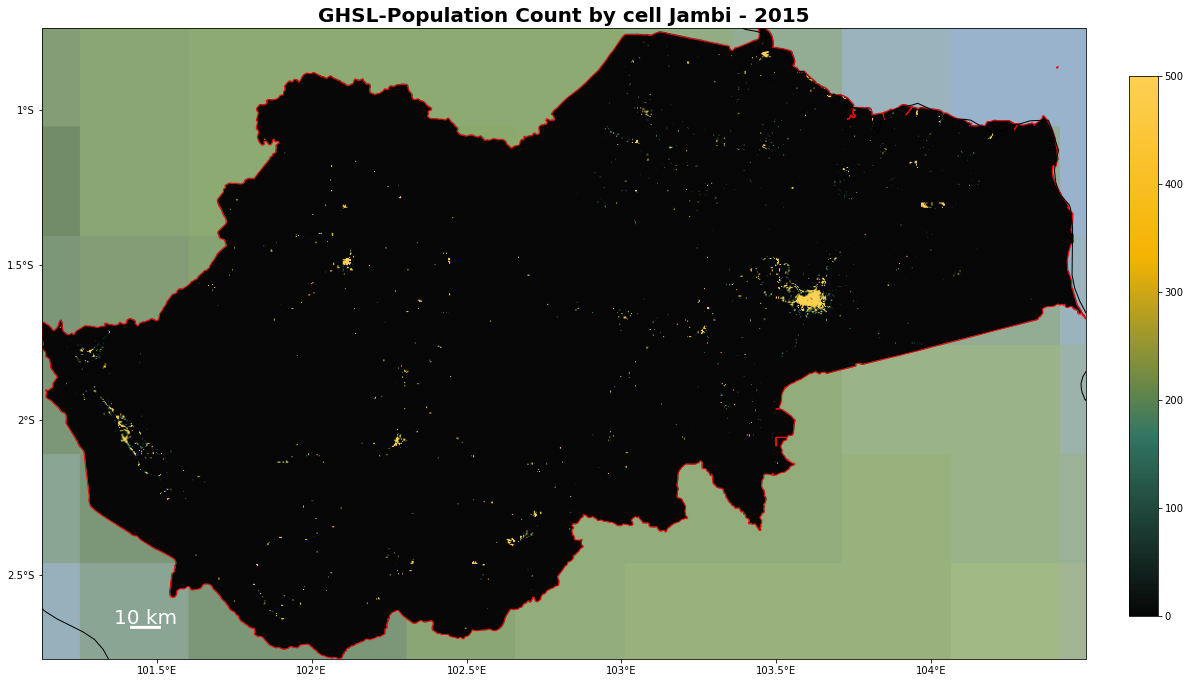

In [23]:
GHSLdataset = ee.ImageCollection(ee.List.sequence(2015,2015,1).map(get_GHSL_images)).first()
fig_ghsl = plt.figure(figsize=(20, 15),  facecolor = 'white', frameon=True)

# plot the result with cartoee using a PlateCarre projection (default)
ax_ghsl = cartoee.get_map(
    GHSLdataset,
    vis_params=popCount_visParameter,
    region=bbox_roi,
    basemap=cimgt.Stamen('terrain'),
    zoom_level=2,
)
ax_ghsl = roi_proj_4326.plot(color = None, edgecolor = 'red', facecolor="none", ax = ax_ghsl)
cb_ghsl = cartoee.add_colorbar(ax_ghsl, vis_params=popCount_visParameter, loc='right', cmap = cmap_GPWPopCount )

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax_ghsl, interval=[0.5, 0.5],alpha=0, linestyle=":")
cartoee.add_scale_bar_lite(ax_ghsl, **scale_bar_dict)
ax_ghsl.set_title(label='GHSL-Population Count by cell '+  projectname + " - 2015", fontsize=20, fontweight="bold")

ax_ghsl.coastlines()

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig(os.path.join(out_dir, projectname + '_GHSL_PopCount2015_Map.png'), bbox_inches='tight', 
            facecolor=fig_ghsl.get_facecolor())
plt.show()

In [24]:
#GHSL_timelapse_visParam = {'bands' : 'population_count', 'min' : 0, 'max': 100}
cartoee.get_image_collection_gif(
    ee_ic = collection_GHSL,
    out_dir = os.path.expanduser(out_dir + '/GHSL_TimeLapse_PopCount'),
    out_gif = projectname + "_GHSL_PopCount2000_2015.gif",
    vis_params = popCount_visParameter,
    region = bbox_roi,
    #cmap = 'hot',
    fps = 5,
    mp4 = False,
    grid_interval = (0.5, 0.5),
    plot_title = projectname + " - Population Count per cell",
    date_format='YYYY',
    fig_size=(15, 12),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

GIF saved to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Global Population Assessment\Jambi_Demo\geemap_PopulationAssessment\GHSL_TimeLapse_PopCount\Jambi_GHSL_PopCount2000_2015.gif


#### Raster data

In [69]:
# 1. GPW Population Density 2000
geemap.ee_export_image_to_drive(
    GHSL_PopCount_2000_proj,
    description = projectname + '_GHSL_PopCount_2000_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GHSL_PopCount_2000_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)
# 2. GPW Population Density 2015
geemap.ee_export_image_to_drive(
    GHSL_PopCount_2015_proj,
    description = projectname + '_GHSL_PopCount_2015_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_GHSL_PopCount_2015_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## WorldPop Global Project Population Data: Estimated Residential Population per 100x100m Grid Square 

Recent census-based population counts matched to their associated administrative units are disaggregated to ~100x100m grid cells through machine learning approaches that exploit the relationships between population densities and a range of geospatial covariate layers. The mapping approach is Random Forest-based dasymetric redistribution. This dataset depict estimated number of people residing in each grid cell in 2010, 2015, and other years.

The value represent estimated number of people residing in each grid cell (Resolution = 100 meter)

In [25]:
# 1. WorldPop 2000
WorldPop_dataset_2000 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2000-01-01', '2000-12-31').median()
WorldPop_dataset_2000_proj = WorldPop_dataset_2000.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
WorldPop_PopCount_2000_proj = WorldPop_dataset_2000_proj.select('population')

# 2. WorldPop 2005
WorldPop_dataset_2005 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2005-01-01', '2005-12-31').median()
WorldPop_dataset_2005_proj = WorldPop_dataset_2005.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
WorldPop_PopCount_2005_proj = WorldPop_dataset_2005_proj.select('population')

# 3. WorldPop 2010
WorldPop_dataset_2010 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2010-01-01', '2010-12-31').median()
WorldPop_dataset_2010_proj = WorldPop_dataset_2010.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
WorldPop_PopCount_2010_proj = WorldPop_dataset_2010_proj.select('population')

# 4. WorldPop 2015
WorldPop_dataset_2015 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2015-01-01', '2015-12-31').median()
WorldPop_dataset_2015_proj = WorldPop_dataset_2015.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
WorldPop_PopCount_2015_proj = WorldPop_dataset_2015_proj.select('population')

# 5. WorldPop 2020
WorldPop_dataset_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01', '2020-12-31').median()
WorldPop_dataset_2020_proj = WorldPop_dataset_2020.reproject(crs = projection, scale = 250).clip(roi_proj_gee)
WorldPop_PopCount_2020_proj = WorldPop_dataset_2020_proj.select('population')


In [26]:
worldpopCount_visParameter = {'palette': ['060606', '337663', 'f5b301', 'fed053'], 'min' : 0, 'max': 50};
colors_worldpopCount_PopCount = ['060606', '337663', 'f5b301', 'fed053']
cmap_worldpopCount = ListedColormap(colors_worldpopCount_PopCount)

In [72]:
Map3 = geemap.Map()
Map3.add_basemap('HYBRID')

Map3.centerObject(roi_proj_gee, 8)

# Add individual layer map
Map3.addLayer(WorldPop_PopCount_2000_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2000')
Map3.addLayer(WorldPop_PopCount_2005_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2005')
Map3.addLayer(WorldPop_PopCount_2010_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2010')
Map3.addLayer(WorldPop_PopCount_2015_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2015')
Map3.addLayer(WorldPop_PopCount_2020_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2020')
Map3.addLayer(roi_proj_gee.style(**vis_roi), {}, "Region of Interest")

Map3

Map(center=[-1.698463590692844, 102.71996498503798], controls=(WidgetControl(options=['position', 'transparent…

In [27]:
SplitMap3 = geemap.Map()
SplitMap3.add_basemap('HYBRID')

SplitMap3.centerObject(roi_proj_gee, 8)

left_layer3 = geemap.ee_tile_layer(WorldPop_PopCount_2000_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2000')
right_layer3 = geemap.ee_tile_layer(WorldPop_PopCount_2020_proj, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2020')
SplitMap3.split_map(left_layer3, right_layer3)
SplitMap3

Map(center=[-1.698463590692844, 102.71996498503798], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### Map

In [28]:
years_WorldPop = ee.List.sequence(2000, 2020, 5)

def get_WorldPop_images(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection('WorldPop/GP/100m/pop')
        .filterDate(start_date, end_date)
        .select('population')
    )
    return ee.Image(image)

collection_WorldPop = ee.ImageCollection(years_WorldPop.map(get_WorldPop_images))

In [29]:
WorldMapdataset = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01','2020-12-31').median().clip(roi_proj_4326_gee)

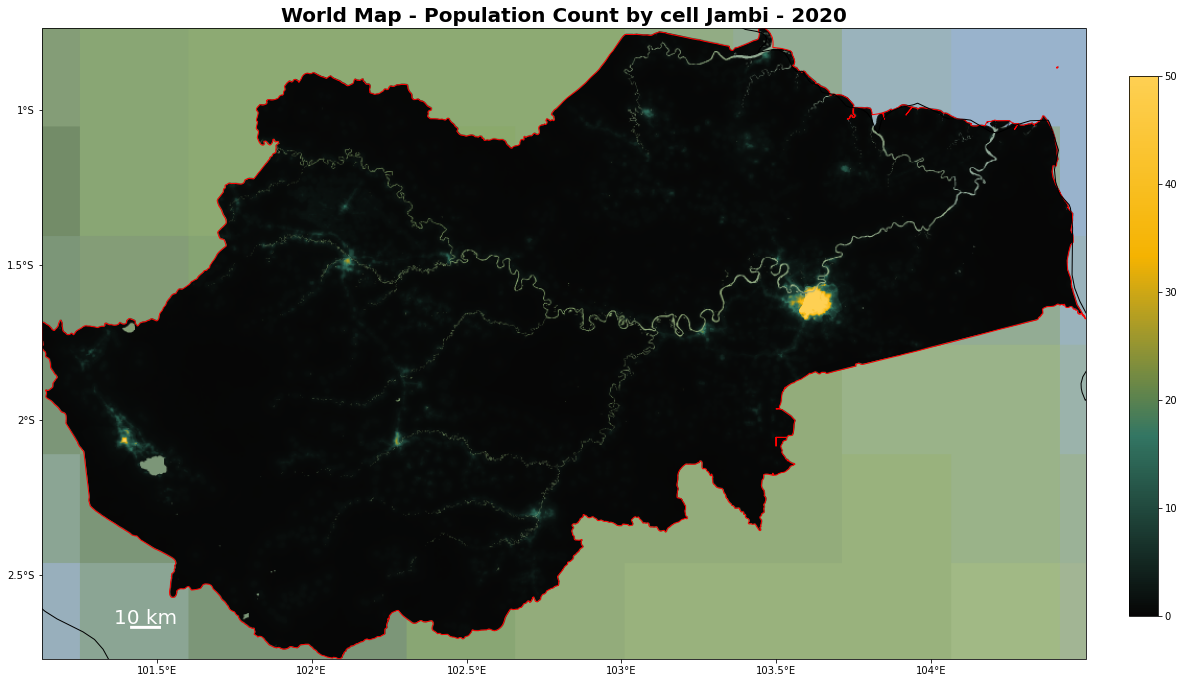

In [30]:
fig_WorldMap = plt.figure(figsize=(20, 15),  facecolor = 'white', frameon=True)

# plot the result with cartoee using a PlateCarre projection (default)
ax_WorldMap = cartoee.get_map(
    WorldMapdataset,
    vis_params=worldpopCount_visParameter,
    region=bbox_roi,
    basemap=cimgt.Stamen('terrain'),
    zoom_level=2,
)
ax_WorldMap = roi_proj_4326.plot(color = None, edgecolor = 'red', facecolor="none", ax = ax_WorldMap)
cb_WorldMap = cartoee.add_colorbar(ax_WorldMap, vis_params=worldpopCount_visParameter, loc='right', cmap = cmap_worldpopCount )

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax_WorldMap, interval=[0.5, 0.5],alpha=0, linestyle=":")
cartoee.add_scale_bar_lite(ax_WorldMap, **scale_bar_dict)
ax_WorldMap.set_title(label='World Map - Population Count by cell '+  projectname + " - 2020", fontsize=20, fontweight="bold")

ax_WorldMap.coastlines()

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig(os.path.join(out_dir, projectname + '_WorldMap_PopCount2020_Map.png'), bbox_inches='tight', 
            facecolor=fig_WorldMap.get_facecolor())
plt.show()

#### Raster Data

In [31]:
# 1. WorldPop Population Density 2000
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2000_proj,
    description = projectname + '_WorldPop_PopCount_2000_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2000_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. WorldPop Population Density 2005
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2005_proj,
    description = projectname + '_WorldPop_PopCount_2005_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2005_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 3. WorldPop Population Density 2010
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2010_proj,
    description = projectname + '_WorldPop_PopCount_2010_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2010_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 4. WorldPop Population Density 2015
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2015_proj,
    description = projectname + '_WorldPop_PopCount_2015_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2015_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 5. WorldPop Population Density 2020
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2020_proj,
    description = projectname + '_WorldPop_PopCount_2020_roi',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2020_roi',
    scale = 1000,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)